In [222]:
import pandas as pd
import matplotlib.pyplot as plt
import platform
from matplotlib import font_manager, rc
import datetime 
rc('font', family='AppleGothic') 			
plt.rcParams['axes.unicode_minus'] = False
nameArray = ['박하원','하효은','이민우','강명균','유지원','손정민','이채별']
colors = ['tab:blue', 'tab:orange', 'tab:green']
count = 0

In [122]:
#하원, 효은, 민우, 명균, 지원, 정민, 채별 
startDate = '20230420'
endDate = '20230630'
studentDfArr = []
indexNameArray = ['hr','hr_conv','br','br_conv','mot','r','speed','temperature','humidity','d2']
deviceNumArray = ['850', '341','855','853','287','848','340']

for i in range(7):
    url = 'http://52.231.67.67:3000/api/sensorData/duration?deviceNo='+deviceNumArray[i]+'&startDate=' + startDate + '&endDate=' + endDate
    studentDfArr.append(pd.read_json(url))
    print(len(studentDfArr[i]))



27733
20246
74028
20926
22999
9085
51882


In [124]:
sleep = pd.read_csv("/Users/hyennaeon/Desktop/Hatinroo/HatinrooData/수면_활동_부재_수집데이터/SleepData.csv")
active = pd.read_csv("/Users/hyennaeon/Desktop/Hatinroo/HatinrooData/수면_활동_부재_수집데이터/ActiveData.csv")
absence = pd.read_csv("/Users/hyennaeon/Desktop/Hatinroo/HatinrooData/수면_활동_부재_수집데이터/AbsenceData.csv")
resultDf = pd.DataFrame()

In [629]:
motQuntaile50Array = []
motQuntaile70Array = []

test = sleep
for i in range(7):
    # motQuntaile50Array.append(test[(test['userId'] == i) & (test['status'] == 4)]['mot'].quantile(.7))
    df = pd.DataFrame(studentDfArr[i])
    df = df[(df['hr'] != 0) & (df['status'] == 4)]
    motQuntaile50Array.append(df['mot'].mean()/10)
    print(df['mot'].mean()/10)
    # motQuntaile50Array.append(0)
    

0.010375134746676248
0.0028589702072538857
0.003492957746478874
0.008057171117705242
0.010288860103626944
0.005210479175996418
0.011532763532763533


수면 성능 평가

In [630]:
test = sleep
test['real_label'] = 4
result_df = pd.DataFrame()

for i in range(7):
    test1 = test[test['userId'] == i]
    test1['label'] = 5

    cond_1 = (
        (test1['d2'].isnull())
        & (test1['hr_conv'] == 0)
        & (test1['br_conv'] == 0)
        & ((test1['mot'] == 0 ) | (test1['speed'] == 0))
    )

    cond_1_1 = (
        (~test1['d2'].isnull()) 
        & (test1['d2'] < test1[test1['d2'] > 0 ]['d2'].min() * 1.4)
    )

    test1.loc[cond_1, 'label'] = 0
    test1.loc[cond_1_1, 'label'] = 0

    cond_2 = (
        (test1['light'].rolling(10).sum() < 10)
        & (test1['label'] != 0)
    )

    test1.loc[cond_2, 'label'] = 4
    test1.loc[test1['label'] == 5, 'label'] = 1

    cond_3 = (
        (test1[test1['userId'] == i]['mot'].rolling(10).mean() <= motQuntaile50Array[i]) 
        & (test1['label'] == 1)
    )

    test1.loc[cond_3, 'label'] = 4

    result_df = pd.concat([result_df, test1], ignore_index=True)
    print(len(test1))

resultDf = pd.concat([resultDf, result_df], ignore_index=True)

/var/folders/3c/mjclf_6d0wlfk3rpvcxcvdz80000gn/T/ipykernel_42898/907356067.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test1['label'] = 5
/var/folders/3c/mjclf_6d0wlfk3rpvcxcvdz80000gn/T/ipykernel_42898/907356067.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test1['label'] = 5
/var/folders/3c/mjclf_6d0wlfk3rpvcxcvdz80000gn/T/ipykernel_42898/907356067.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value

3046
1435
667
1558
2098
1622
2035


In [631]:
# test['label'].value_counts()
print(len(result_df[result_df['label'] == 0])/len(result_df))
print(len(result_df[result_df['label'] == 1])/len(result_df))
print(len(result_df[result_df['label'] == 4])/len(result_df))

0.07094133697135062
0.09670170933311933
0.8323569536955301


In [632]:
#학생별 수치 확인
for i in range(7):
    test2 = result_df[result_df['userId'] == i]
    print(nameArray[i])
    print(f"기존Status 부재 비율:{len(test2[test2['status'] == 0])/len(test2)}")
    print(f"기존Status 비수면재실 비율: {len(test2[(test2['status'] == 2) | (test2['status'] == 3)])/len(test2)}")
    print(f"기존Status 수면 비율: {len(test2[test2['status'] == 4])/len(test2)}")
    print("\n")
    print(f"newStatus 부재 비율:{len(test2[test2['label'] == 0])/len(test2)}")
    print(f"newStatus 비수면재실 비율: {len(test2[test2['label'] == 1])/len(test2)}")
    print(f"newStatus 수면 비율: {len(test2[test2['label'] == 4])/len(test2)}")
    print("\n\n")

박하원
기존Status 부재 비율:0.09290873276428102
기존Status 비수면재실 비율: 0.4980302035456336
기존Status 수면 비율: 0.4090610636900854


newStatus 부재 비율:0.05712409717662508
newStatus 비수면재실 비율: 0.06992777413000656
newStatus 수면 비율: 0.8729481286933684



하효은
기존Status 부재 비율:0.0
기존Status 비수면재실 비율: 0.008362369337979094
기존Status 수면 비율: 0.9916376306620209


newStatus 부재 비율:0.0013937282229965157
newStatus 비수면재실 비율: 0.0062717770034843206
newStatus 수면 비율: 0.9923344947735192



이민우
기존Status 부재 비율:0.0
기존Status 비수면재실 비율: 0.06596701649175413
기존Status 수면 비율: 0.9340329835082459


newStatus 부재 비율:0.008995502248875561
newStatus 비수면재실 비율: 0.15142428785607195
newStatus 수면 비율: 0.8395802098950524



강명균
기존Status 부재 비율:0.0
기존Status 비수면재실 비율: 0.0
기존Status 수면 비율: 1.0


newStatus 부재 비율:0.005776636713735558
newStatus 비수면재실 비율: 0.005776636713735558
newStatus 수면 비율: 0.9884467265725289



유지원
기존Status 부재 비율:0.21830314585319352
기존Status 비수면재실 비율: 0.5810295519542421
기존Status 수면 비율: 0.20066730219256435


newStatus 부재 비율:0.1544327931363203
ne

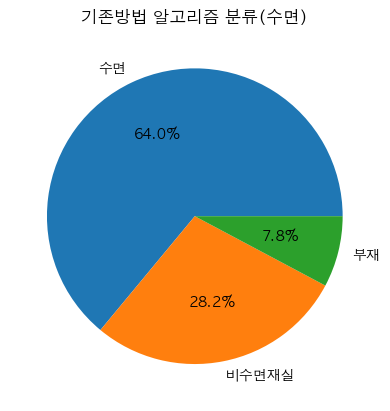

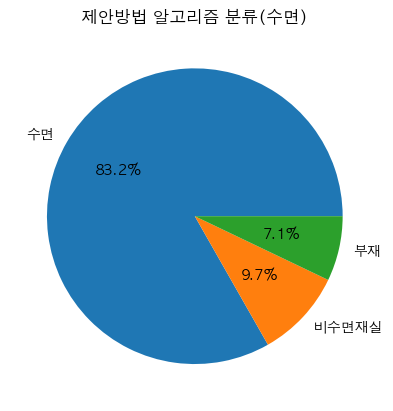

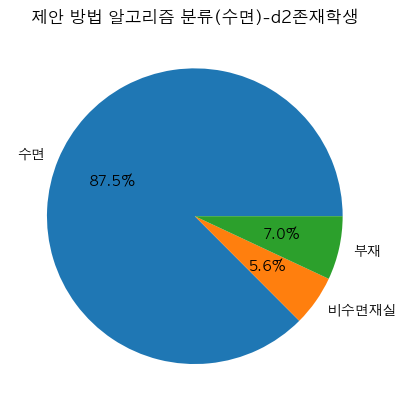

In [633]:
statusSleep = len(result_df[result_df['status'] == 4])/len(result_df)
statusAbsence = len(result_df[result_df['status'] == 0])/len(result_df)
statusActive = len(result_df[(result_df['status'] == 2) | (result_df['status'] == 3)])/len(result_df)
plt.pie([statusSleep, statusActive, statusAbsence], labels=['수면','비수면재실', '부재'],colors=colors, autopct='%.1f%%')
plt.title('기존방법 알고리즘 분류(수면)')
# plt.savefig(f"./figs/noname{ㅊ}.png", bbox_inches='tight')
plt.show()

labelSleep = len(result_df[result_df['label'] == 4])/len(result_df)
labelAbsence = len(result_df[result_df['label'] == 0])/len(result_df)
labelActive = len(result_df[result_df['label'] == 1])/len(result_df)
plt.pie([labelSleep, labelActive, labelAbsence], labels=['수면', '비수면재실', '부재'],colors=colors, autopct='%.1f%%')
plt.title('제안방법 알고리즘 분류(수면)')
# plt.savefig("./figs/absence(강남대).png", bbox_inches='tight')
plt.show()

df = result_df[(result_df['userId']==0)|(result_df['userId']==2)|(result_df['userId']==3)|(result_df['userId']==4)]
d2labelSleep = len(df[df['label'] == 4])/len(df)
d2labelAbsence = len(df[df['label'] == 0])/len(df)
d2labelActive = len(df[df['label'] == 1])/len(df)
plt.pie([d2labelSleep, d2labelActive, d2labelAbsence], labels=['수면', '비수면재실', '부재'], autopct='%.1f%%',colors=colors)
plt.title('제안 방법 알고리즘 분류(수면)-d2존재학생')
# plt.savefig("./figs/absence(강남대).png", bbox_inches='tight')
plt.show()

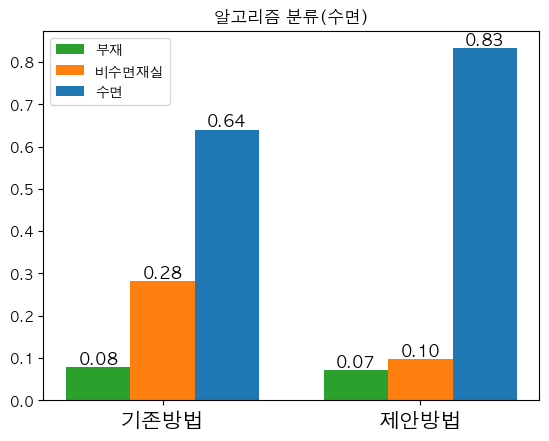

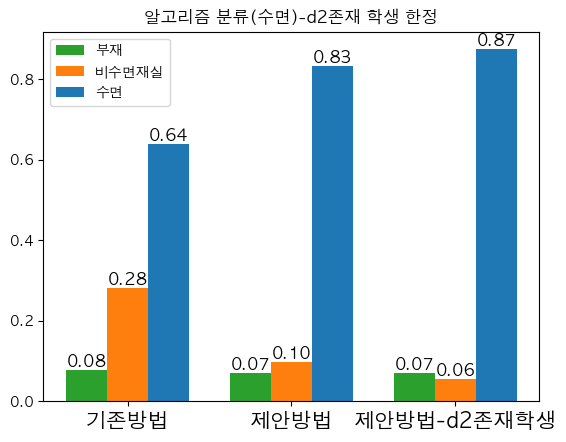

In [634]:
X1=[1,3]
data1 = [statusAbsence,labelAbsence]
bar1 = plt.bar(X1, data1,color='tab:green',width=0.5)

for rect in bar1:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width()/2.0, height, '%.2f' % height, ha='center', va='bottom', size = 12)    

X2=[1+0.5,3+0.5]
data2 = [statusActive,labelActive]
bar2 = plt.bar(X2, data2,color='tab:orange',width=0.5)

for rect in bar2:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width()/2.0, height, '%.2f' % height, ha='center', va='bottom', size = 12)  

X3=[1+1,3+1]
data3 = [statusSleep,labelSleep]
bar3 = plt.bar(X3, data3,color='tab:blue',width=0.5)

for rect in bar3:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width()/2.0, height, '%.2f' % height, ha='center', va='bottom', size = 12)  

ticklabel=['기존방법','제안방법']
plt.title('알고리즘 분류(수면)')
plt.xticks(X2,ticklabel,fontsize=15,rotation=0)
plt.legend(['부재','비수면재실','수면'])
plt.show()

X1=[1,3,5]
data1 = [statusAbsence,labelAbsence,d2labelAbsence]
bar1 = plt.bar(X1, data1,color='tab:green',width=0.5)

for rect in bar1:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width()/2.0, height, '%.2f' % height, ha='center', va='bottom', size = 12)    

X2=[1+0.5,3+0.5,5+0.5]
data2 = [statusActive,labelActive,d2labelActive]
bar2 = plt.bar(X2, data2,color='tab:orange',width=0.5)

for rect in bar2:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width()/2.0, height, '%.2f' % height, ha='center', va='bottom', size = 12)  

X3=[1+1,3+1,5+1]
data3 = [statusSleep,labelSleep,d2labelSleep]
bar3 = plt.bar(X3, data3,color='tab:blue',width=0.5)

for rect in bar3:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width()/2.0, height, '%.2f' % height, ha='center', va='bottom', size = 12)  

ticklabel=['기존방법','제안방법','제안방법-d2존재학생']
plt.title('알고리즘 분류(수면)-d2존재 학생 한정')
plt.xticks(X2,ticklabel,fontsize=15,rotation=0)
plt.legend(['부재','비수면재실','수면'])
plt.show()


In [635]:
test = sleep
test['real_label'] = 1
result_df = pd.DataFrame()

for i in range(7):
    test1 = test[test['userId'] == i]
    test1['label'] = 5

    cond_1 = (
        (test1['d2'].isnull())
        & (test1['hr_conv'] == 0)
        & (test1['br_conv'] == 0)
        & ((test1['mot'] == 0 ) | (test1['speed'] == 0))
    )

    cond_1_1 = (
        (~test1['d2'].isnull())
        & (test1['d2'] < test1[test1['d2'] > 0 ]['d2'].min() * 1.4)
    )

    test1.loc[cond_1, 'label'] = 0
    test1.loc[cond_1_1, 'label'] = 0

    cond_2 = (
        (test1['light'].rolling(10).sum() < 10)
        & (test1['label'] != 0)
    )

    test1.loc[cond_2, 'label'] = 4
    test1.loc[test1['label'] == 5, 'label'] = 1

    cond_3 = (
        (test1[test1['userId'] == i]['mot'].rolling(10).mean() <= 0)
        & (test1['label'] == 1)
    )

    test1.loc[cond_3, 'label'] = 4

    result_df = pd.concat([result_df, test1], ignore_index=True)


/var/folders/3c/mjclf_6d0wlfk3rpvcxcvdz80000gn/T/ipykernel_42898/3599053368.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test1['label'] = 5
/var/folders/3c/mjclf_6d0wlfk3rpvcxcvdz80000gn/T/ipykernel_42898/3599053368.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test1['label'] = 5
/var/folders/3c/mjclf_6d0wlfk3rpvcxcvdz80000gn/T/ipykernel_42898/3599053368.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = va

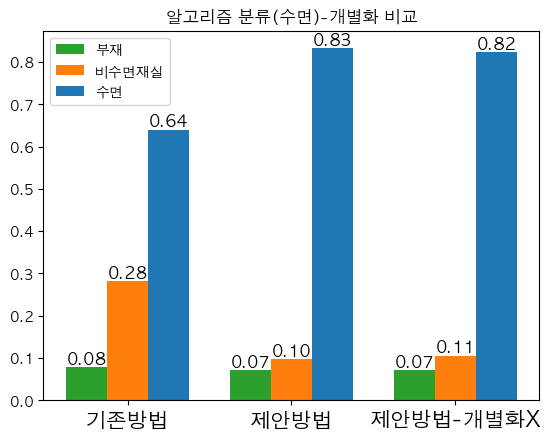

In [636]:
noPersLabelSleep = len(result_df[result_df['label'] == 4])/len(result_df)
noPersLabelAbsence = len(result_df[result_df['label'] == 0])/len(result_df)
noPersLabelActive = len(result_df[result_df['label'] == 1])/len(result_df)
X1=[1,3,5]
data1 = [statusAbsence,labelAbsence,noPersLabelAbsence]
bar1 = plt.bar(X1, data1,color='tab:green',width=0.5)

for rect in bar1:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width()/2.0, height, '%.2f' % height, ha='center', va='bottom', size = 12)    

X2=[1+0.5,3+0.5,5+0.5]
data2 = [statusActive,labelActive,noPersLabelActive]
bar2 = plt.bar(X2, data2,color='tab:orange',width=0.5)

for rect in bar2:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width()/2.0, height, '%.2f' % height, ha='center', va='bottom', size = 12)  

X3=[1+1,3+1,5+1]
data3 = [statusSleep,labelSleep,noPersLabelSleep]
bar3 = plt.bar(X3, data3,color='tab:blue',width=0.5)

for rect in bar3:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width()/2.0, height, '%.2f' % height, ha='center', va='bottom', size = 12)  

ticklabel=['기존방법','제안방법','제안방법-개별화X']
plt.title('알고리즘 분류(수면)-개별화 비교')
plt.xticks(X2,ticklabel,fontsize=15,rotation=0)
plt.legend(['부재','비수면재실','수면'])


비수면 재실 성능 평가

In [637]:
test = active
test['real_label'] = 1
result_df = pd.DataFrame()

for i in range(7):
    test1 = test[test['userId'] == i]
    test1['label'] = 5

    cond_1 = (
        (test1['d2'].isnull())
        & (test1['hr_conv'] == 0)
        & (test1['br_conv'] == 0)
        & ((test1['mot'] == 0 ) | (test1['speed'] == 0))
    )

    cond_1_1 = (
        (~test1['d2'].isnull()) 
        & (test1['d2'] < test1[test1['d2'] > 0 ]['d2'].min() * 1.4)
    )

    test1.loc[cond_1, 'label'] = 0
    test1.loc[cond_1_1, 'label'] = 0

    cond_2 = (
        (test1['light'].rolling(10).sum() < 10)
        & (test1['label'] != 0)
    )

    test1.loc[cond_2, 'label'] = 4
    test1.loc[test1['label'] == 5, 'label'] = 1

    cond_3 = (
        (test1[test1['userId'] == i]['mot'].rolling(10).mean() <= motQuntaile50Array[i]) 
        & (test1['label'] == 1)
    )

    test1.loc[cond_3, 'label'] = 4

    result_df = pd.concat([result_df, test1], ignore_index=True)
    
resultDf = pd.concat([resultDf, result_df], ignore_index=True)

/var/folders/3c/mjclf_6d0wlfk3rpvcxcvdz80000gn/T/ipykernel_42898/3669592483.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test1['label'] = 5
/var/folders/3c/mjclf_6d0wlfk3rpvcxcvdz80000gn/T/ipykernel_42898/3669592483.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test1['label'] = 5
/var/folders/3c/mjclf_6d0wlfk3rpvcxcvdz80000gn/T/ipykernel_42898/3669592483.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = va

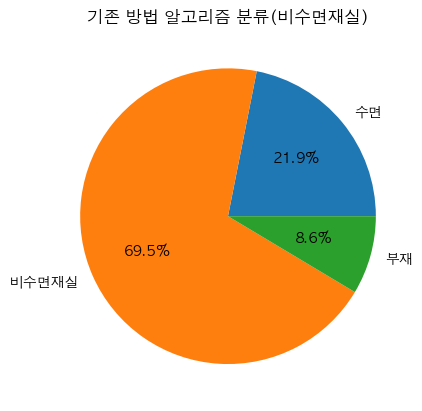

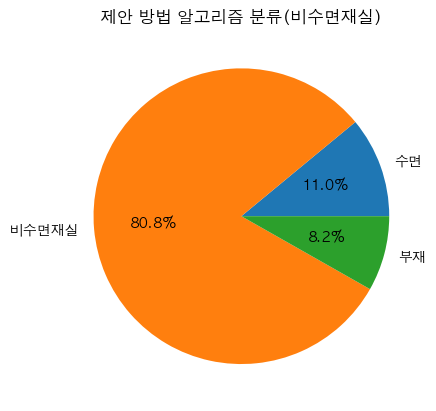

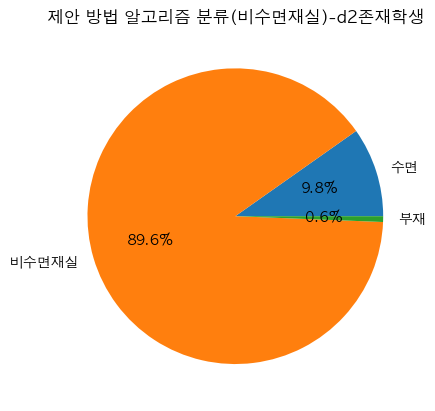

In [638]:
#하틴루 알고리즘, 강남대 알고리즘 전체 비교 시각화

statusSleep = len(result_df[result_df['status'] == 4])/len(result_df)
statusAbsence = len(result_df[result_df['status'] == 0])/len(result_df)
statusActive = len(result_df[(result_df['status'] == 2) | (result_df['status'] == 3)])/len(result_df)
plt.pie([statusSleep, statusActive, statusAbsence], labels=['수면','비수면재실', '부재'], autopct='%.1f%%',colors=colors)
plt.title('기존 방법 알고리즘 분류(비수면재실)')
# plt.savefig("./figs/absence(하틴루).png", bbox_inches='tight')
plt.show()

labelSleep = len(result_df[result_df['label'] == 4])/len(result_df)
labelAbsence = len(result_df[result_df['label'] == 0])/len(result_df)
labelActive = len(result_df[result_df['label'] == 1])/len(result_df)
plt.pie([labelSleep, labelActive, labelAbsence], labels=['수면', '비수면재실', '부재'], autopct='%.1f%%',colors=colors)
plt.title('제안 방법 알고리즘 분류(비수면재실)')
# plt.savefig("./figs/absence(강남대).png", bbox_inches='tight')
plt.show()

df = result_df[(result_df['userId']==0)|(result_df['userId']==2)|(result_df['userId']==3)|(result_df['userId']==4)]
d2labelSleep = len(df[df['label'] == 4])/len(df)
d2labelAbsence = len(df[df['label'] == 0])/len(df)
d2labelActive = len(df[df['label'] == 1])/len(df)
plt.pie([d2labelSleep, d2labelActive, d2labelAbsence], labels=['수면', '비수면재실', '부재'], autopct='%.1f%%',colors=colors)
plt.title('제안 방법 알고리즘 분류(비수면재실)-d2존재학생')
# plt.savefig("./figs/absence(강남대).png", bbox_inches='tight')
plt.show()

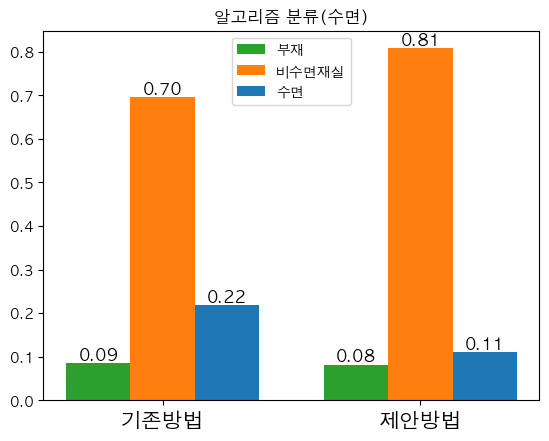

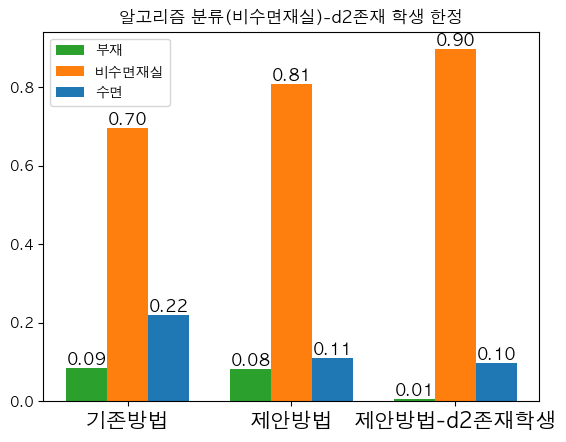

In [639]:
X1=[1,3]
data1 = [statusAbsence,labelAbsence]
bar1 = plt.bar(X1, data1,color='tab:green',width=0.5)

for rect in bar1:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width()/2.0, height, '%.2f' % height, ha='center', va='bottom', size = 12)    

X2=[1+0.5,3+0.5]
data2 = [statusActive,labelActive]
bar2 = plt.bar(X2, data2,color='tab:orange',width=0.5)

for rect in bar2:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width()/2.0, height, '%.2f' % height, ha='center', va='bottom', size = 12)  

X3=[1+1,3+1]
data3 = [statusSleep,labelSleep]
bar3 = plt.bar(X3, data3,color='tab:blue',width=0.5)

for rect in bar3:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width()/2.0, height, '%.2f' % height, ha='center', va='bottom', size = 12)  

ticklabel=['기존방법','제안방법']
plt.title('알고리즘 분류(수면)')
plt.xticks(X2,ticklabel,fontsize=15,rotation=0)
plt.legend(['부재','비수면재실','수면'])
plt.show()

X1=[1,3,5]
data1 = [statusAbsence,labelAbsence,d2labelAbsence]
bar1 = plt.bar(X1, data1,color='tab:green',width=0.5)

for rect in bar1:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width()/2.0, height, '%.2f' % height, ha='center', va='bottom', size = 12)    

X2=[1+0.5,3+0.5,5+0.5]
data2 = [statusActive,labelActive,d2labelActive]
bar2 = plt.bar(X2, data2,color='tab:orange',width=0.5)

for rect in bar2:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width()/2.0, height, '%.2f' % height, ha='center', va='bottom', size = 12)  

X3=[1+1,3+1,5+1]
data3 = [statusSleep,labelSleep,d2labelSleep]
bar3 = plt.bar(X3, data3,color='tab:blue',width=0.5)

for rect in bar3:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width()/2.0, height, '%.2f' % height, ha='center', va='bottom', size = 12)  

ticklabel=['기존방법','제안방법','제안방법-d2존재학생']
plt.title('알고리즘 분류(비수면재실)-d2존재 학생 한정')
plt.xticks(X2,ticklabel,fontsize=15,rotation=0)
plt.legend(['부재','비수면재실','수면'])
plt.show()


In [640]:
#학생별 수치 확인
for i in range(7):
    test2 = result_df[result_df['userId'] == i]
    print(nameArray[i])
    print(f"기존Status 부재 비율:{len(test2[test2['status'] == 0])/len(test2)}")
    print(f"기존Status 비수면재실 비율: {len(test2[(test2['status'] == 2) | (test2['status'] == 3)])/len(test2)}")
    print(f"기존Status 수면 비율: {len(test2[test2['status'] == 4])/len(test2)}")
    print("\n")
    print(f"newStatus 부재 비율:{len(test2[test2['label'] == 0])/len(test2)}")
    print(f"newStatus 비수면재실 비율: {len(test2[test2['label'] == 1])/len(test2)}")
    print(f"newStatus 수면 비율: {len(test2[test2['label'] == 4])/len(test2)}")
    print("\n\n")

박하원
기존Status 부재 비율:0.002354788069073783
기존Status 비수면재실 비율: 0.4835164835164835
기존Status 수면 비율: 0.5141287284144427


newStatus 부재 비율:0.006279434850863423
newStatus 비수면재실 비율: 0.8430141287284144
newStatus 수면 비율: 0.15070643642072212



하효은
기존Status 부재 비율:0.0
기존Status 비수면재실 비율: 0.5205882352941177
기존Status 수면 비율: 0.47941176470588237


newStatus 부재 비율:0.0
newStatus 비수면재실 비율: 0.788235294117647
newStatus 수면 비율: 0.21176470588235294



이민우
기존Status 부재 비율:0.0
기존Status 비수면재실 비율: 0.9050925925925926
기존Status 수면 비율: 0.09490740740740741


newStatus 부재 비율:0.0023148148148148147
newStatus 비수면재실 비율: 0.9027777777777778
newStatus 수면 비율: 0.09490740740740741



강명균
기존Status 부재 비율:0.0
기존Status 비수면재실 비율: 0.776500638569604
기존Status 수면 비율: 0.22349936143039592


newStatus 부재 비율:0.006385696040868455
newStatus 비수면재실 비율: 0.9106002554278416
newStatus 수면 비율: 0.08301404853128991



유지원
기존Status 부재 비율:0.033707865168539325
기존Status 비수면재실 비율: 0.9662921348314607
기존Status 수면 비율: 0.0


newStatus 부재 비율:0.00749063670411985
newSta

In [641]:
test = active
test['real_label'] = 1
result_df = pd.DataFrame()

for i in range(7):
    test1 = test[test['userId'] == i]
    test1['label'] = 5

    cond_1 = (
        (test1['d2'].isnull())
        & (test1['hr_conv'] == 0)
        & (test1['br_conv'] == 0)
        & ((test1['mot'] == 0 ) | (test1['speed'] == 0))
    )

    cond_1_1 = (
        (~test1['d2'].isnull())
        & (test1['d2'] < test1[test1['d2'] > 0 ]['d2'].min() * 1.4)
    )

    test1.loc[cond_1, 'label'] = 0
    test1.loc[cond_1_1, 'label'] = 0

    cond_2 = (
        (test1['light'].rolling(10).sum() < 10)
        & (test1['label'] != 0)
    )

    test1.loc[cond_2, 'label'] = 4
    test1.loc[test1['label'] == 5, 'label'] = 1

    cond_3 = (
        (test1[test1['userId'] == i]['mot'].rolling(10).mean() <= 0)
        & (test1['label'] == 1)
    )

    test1.loc[cond_3, 'label'] = 4

    result_df = pd.concat([result_df, test1], ignore_index=True)


/var/folders/3c/mjclf_6d0wlfk3rpvcxcvdz80000gn/T/ipykernel_42898/2129634483.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test1['label'] = 5
/var/folders/3c/mjclf_6d0wlfk3rpvcxcvdz80000gn/T/ipykernel_42898/2129634483.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test1['label'] = 5
/var/folders/3c/mjclf_6d0wlfk3rpvcxcvdz80000gn/T/ipykernel_42898/2129634483.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = va

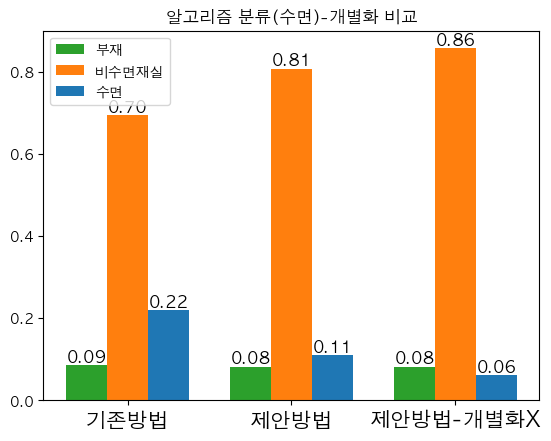

In [642]:
noPersLabelSleep = len(result_df[result_df['label'] == 4])/len(result_df)
noPersLabelAbsence = len(result_df[result_df['label'] == 0])/len(result_df)
noPersLabelActive = len(result_df[result_df['label'] == 1])/len(result_df)
X1=[1,3,5]
data1 = [statusAbsence,labelAbsence,noPersLabelAbsence]
bar1 = plt.bar(X1, data1,color='tab:green',width=0.5)

for rect in bar1:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width()/2.0, height, '%.2f' % height, ha='center', va='bottom', size = 12)    

X2=[1+0.5,3+0.5,5+0.5]
data2 = [statusActive,labelActive,noPersLabelActive]
bar2 = plt.bar(X2, data2,color='tab:orange',width=0.5)

for rect in bar2:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width()/2.0, height, '%.2f' % height, ha='center', va='bottom', size = 12)  

X3=[1+1,3+1,5+1]
data3 = [statusSleep,labelSleep,noPersLabelSleep]
bar3 = plt.bar(X3, data3,color='tab:blue',width=0.5)

for rect in bar3:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width()/2.0, height, '%.2f' % height, ha='center', va='bottom', size = 12)  

ticklabel=['기존방법','제안방법','제안방법-개별화X']
plt.title('알고리즘 분류(수면)-개별화 비교')
plt.xticks(X2,ticklabel,fontsize=15,rotation=0)
plt.legend(['부재','비수면재실','수면'])


부재 성능 평가

In [643]:
test = absence
test['real_label'] = 0
result_df = pd.DataFrame()

for i in range(7):
    test1 = test[test['userId'] == i]
    test1['label'] = 5

    cond_1 = (
        (test1['d2'].isnull())
        & (test1['hr_conv'] == 0)
        & (test1['br_conv'] == 0)
        & ((test1['mot'] == 0 ) | (test1['speed'] == 0))
    )

    cond_1_1 = (
        (~test1['d2'].isnull()) 
        & (test1['d2'] < test1[test1['d2'] > 0 ]['d2'].min() * 1.4)
    )

    test1.loc[cond_1, 'label'] = 0
    test1.loc[cond_1_1, 'label'] = 0

    cond_2 = (
        (test1['light'].rolling(10).sum() < 10)
        & (test1['label'] != 0)
    )

    test1.loc[cond_2, 'label'] = 4
    test1.loc[test1['label'] == 5, 'label'] = 1

    cond_3 = (
        (test1[test1['userId'] == i]['mot'].rolling(15).mean() <= motQuntaile50Array[i]) 
        & (test1['label'] == 1)
    )

    test1.loc[cond_3, 'label'] = 4

    result_df = pd.concat([result_df, test1], ignore_index=True)

resultDf = pd.concat([resultDf, result_df], ignore_index=True)

/var/folders/3c/mjclf_6d0wlfk3rpvcxcvdz80000gn/T/ipykernel_42898/1085284888.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test1['label'] = 5
/var/folders/3c/mjclf_6d0wlfk3rpvcxcvdz80000gn/T/ipykernel_42898/1085284888.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test1['label'] = 5
/var/folders/3c/mjclf_6d0wlfk3rpvcxcvdz80000gn/T/ipykernel_42898/1085284888.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = va

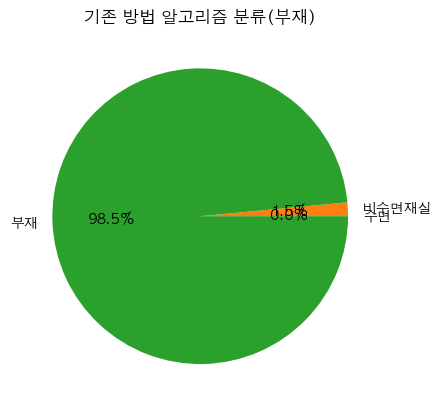

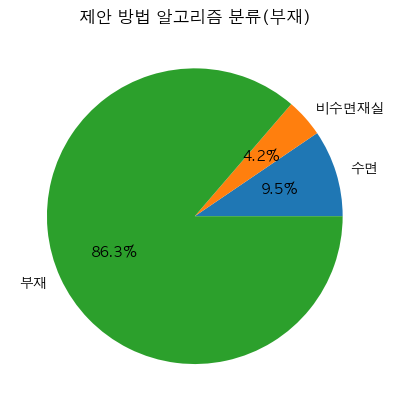

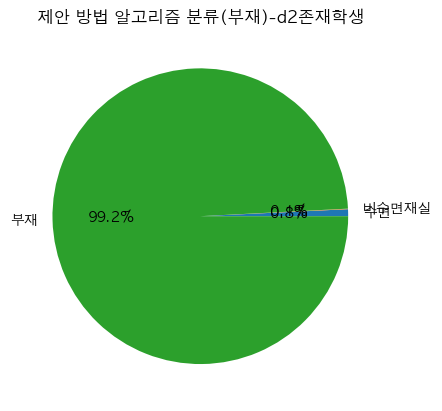

In [644]:
#하틴루 알고리즘, 강남대 알고리즘 전체 비교 시각화

statusSleep = len(result_df[result_df['status'] == 4])/len(result_df)
statusAbsence = len(result_df[result_df['status'] == 0])/len(result_df)
statusActive = len(result_df[(result_df['status'] == 2) | (result_df['status'] == 3)])/len(result_df)
plt.pie([statusSleep, statusActive, statusAbsence], labels=['수면','비수면재실', '부재'], autopct='%.1f%%',colors=colors)
plt.title('기존 방법 알고리즘 분류(부재)')
# plt.savefig("./figs/absence(하틴루).png", bbox_inches='tight')
plt.show()

labelSleep = len(result_df[result_df['label'] == 4])/len(result_df)
labelAbsence = len(result_df[result_df['label'] == 0])/len(result_df)
labelActive = len(result_df[result_df['label'] == 1])/len(result_df)
plt.pie([labelSleep, labelActive, labelAbsence], labels=['수면', '비수면재실', '부재'], autopct='%.1f%%',colors=colors)
plt.title('제안 방법 알고리즘 분류(부재)')
# plt.savefig("./figs/absence(강남대).png", bbox_inches='tight')
plt.show()

df = result_df[(result_df['userId']==0)|(result_df['userId']==2)|(result_df['userId']==3)|(result_df['userId']==5)]
d2labelSleep = len(df[df['label'] == 4])/len(df)
d2labelAbsence = len(df[df['label'] == 0])/len(df)
d2labelActive = len(df[df['label'] == 1])/len(df)
plt.pie([d2labelSleep, d2labelActive, d2labelAbsence], labels=['수면', '비수면재실', '부재'], autopct='%.1f%%',colors=colors)
plt.title('제안 방법 알고리즘 분류(부재)-d2존재학생')
# plt.savefig("./figs/absence(강남대).png", bbox_inches='tight')
plt.show()


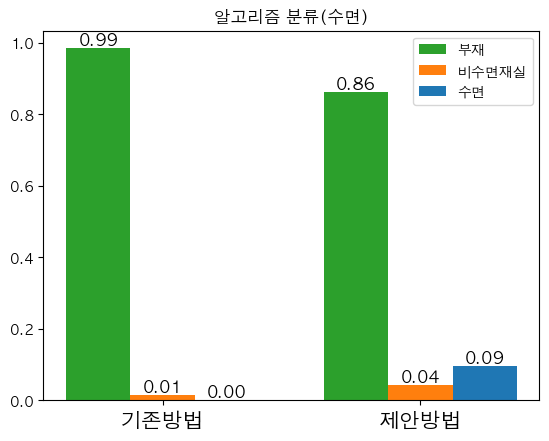

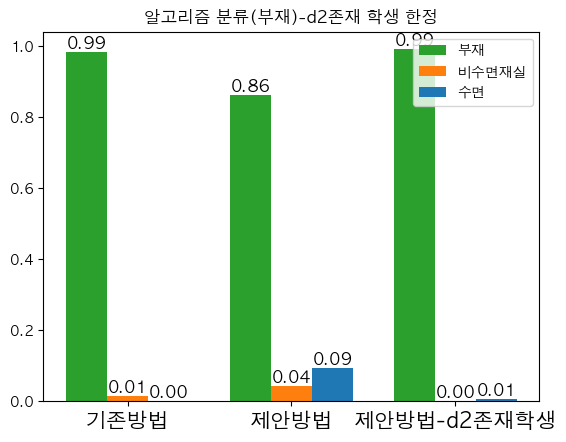

In [645]:
X1=[1,3]
data1 = [statusAbsence,labelAbsence]
bar1 = plt.bar(X1, data1,color='tab:green',width=0.5)

for rect in bar1:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width()/2.0, height, '%.2f' % height, ha='center', va='bottom', size = 12)    

X2=[1+0.5,3+0.5]
data2 = [statusActive,labelActive]
bar2 = plt.bar(X2, data2,color='tab:orange',width=0.5)

for rect in bar2:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width()/2.0, height, '%.2f' % height, ha='center', va='bottom', size = 12)  

X3=[1+1,3+1]
data3 = [statusSleep,labelSleep]
bar3 = plt.bar(X3, data3,color='tab:blue',width=0.5)

for rect in bar3:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width()/2.0, height, '%.2f' % height, ha='center', va='bottom', size = 12)  

ticklabel=['기존방법','제안방법']
plt.title('알고리즘 분류(수면)')
plt.xticks(X2,ticklabel,fontsize=15,rotation=0)
plt.legend(['부재','비수면재실','수면'])
plt.show()

X1=[1,3,5]
data1 = [statusAbsence,labelAbsence,d2labelAbsence]
bar1 = plt.bar(X1, data1,color='tab:green',width=0.5)

for rect in bar1:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width()/2.0, height, '%.2f' % height, ha='center', va='bottom', size = 12)    

X2=[1+0.5,3+0.5,5+0.5]
data2 = [statusActive,labelActive,d2labelActive]
bar2 = plt.bar(X2, data2,color='tab:orange',width=0.5)

for rect in bar2:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width()/2.0, height, '%.2f' % height, ha='center', va='bottom', size = 12)  

X3=[1+1,3+1,5+1]
data3 = [statusSleep,labelSleep,d2labelSleep]
bar3 = plt.bar(X3, data3,color='tab:blue',width=0.5)

for rect in bar3:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width()/2.0, height, '%.2f' % height, ha='center', va='bottom', size = 12)  

ticklabel=['기존방법','제안방법','제안방법-d2존재학생']
plt.title('알고리즘 분류(부재)-d2존재 학생 한정')
plt.xticks(X2,ticklabel,fontsize=15,rotation=0)
plt.legend(['부재','비수면재실','수면'])
plt.show()


In [646]:
#학생별 수치 확인
for i in range(7):
    test2 = result_df[result_df['userId'] == i]
    print(nameArray[i])
    print(f"기존Status 부재 비율:{len(test2[test2['status'] == 0])/len(test2)}")
    print(f"기존Status 비수면재실 비율: {len(test2[(test2['status'] == 2) | (test2['status'] == 3)])/len(test2)}")
    print(f"기존Status 수면 비율: {len(test2[test2['status'] == 4])/len(test2)}")
    print("\n")
    print(f"newStatus 부재 비율:{len(test2[test2['label'] == 0])/len(test2)}")
    print(f"newStatus 비수면재실 비율: {len(test2[test2['label'] == 1])/len(test2)}")
    print(f"newStatus 수면 비율: {len(test2[test2['label'] == 4])/len(test2)}")
    print("\n\n")

박하원
기존Status 부재 비율:0.9726890756302521
기존Status 비수면재실 비율: 0.0273109243697479
기존Status 수면 비율: 0.0


newStatus 부재 비율:0.9695378151260504
newStatus 비수면재실 비율: 0.0021008403361344537
newStatus 수면 비율: 0.028361344537815126



하효은
기존Status 부재 비율:1.0
기존Status 비수면재실 비율: 0.0
기존Status 수면 비율: 0.0


newStatus 부재 비율:0.9406976744186046
newStatus 비수면재실 비율: 0.02558139534883721
newStatus 수면 비율: 0.03372093023255814



이민우
기존Status 부재 비율:1.0
기존Status 비수면재실 비율: 0.0
기존Status 수면 비율: 0.0


newStatus 부재 비율:1.0
newStatus 비수면재실 비율: 0.0
newStatus 수면 비율: 0.0



강명균
기존Status 부재 비율:1.0
기존Status 비수면재실 비율: 0.0
기존Status 수면 비율: 0.0


newStatus 부재 비율:1.0
newStatus 비수면재실 비율: 0.0
newStatus 수면 비율: 0.0



유지원
기존Status 부재 비율:0.9942339373970346
기존Status 비수면재실 비율: 0.005766062602965404
기존Status 수면 비율: 0.0


newStatus 부재 비율:0.5683690280065898
newStatus 비수면재실 비율: 0.009884678747940691
newStatus 수면 비율: 0.42174629324546953



손정민
기존Status 부재 비율:1.0
기존Status 비수면재실 비율: 0.0
기존Status 수면 비율: 0.0


newStatus 부재 비율:1.0
newStatus 비수면재실 비율: 0.0
n

근거 찾기

In [647]:
test = sleep
result_df = pd.DataFrame()

for i in range(7):
    test1 = test[test['userId'] == i]
    test1['label'] = 5

    cond_1 = (
        (test1['d2'].isnull())
        & (test1['hr_conv'] == 0)
        & (test1['br_conv'] == 0)
        & ((test1['mot'] == 0 ) | (test1['speed'] == 0))
    )

    cond_1_1 = (
        (~test1['d2'].isnull()) 
        & (test1['d2'] < test1[test1['d2'] > 0 ]['d2'].min() * 1.4)
    )

    test1.loc[cond_1, 'label'] = 0
    test1.loc[cond_1_1, 'label'] = 0

    cond_2 = (
        (test1['light'].rolling(10).sum() < 10)
        & (test1['label'] != 0)
    )

    test1.loc[cond_2, 'label'] = 4
    test1.loc[test1['label'] == 5, 'label'] = 1

    cond_3 = (
        (test1[test1['userId'] == i]['mot'].rolling(15).mean() <= motQuntaile50Array[i]) 
        & (test1['label'] == 1)
    )

    test1.loc[cond_3, 'label'] = 4

    result_df = pd.concat([result_df, test1], ignore_index=True)


/var/folders/3c/mjclf_6d0wlfk3rpvcxcvdz80000gn/T/ipykernel_42898/2692237878.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test1['label'] = 5
/var/folders/3c/mjclf_6d0wlfk3rpvcxcvdz80000gn/T/ipykernel_42898/2692237878.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test1['label'] = 5
/var/folders/3c/mjclf_6d0wlfk3rpvcxcvdz80000gn/T/ipykernel_42898/2692237878.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = va

성능평가

In [648]:
print(len(resultDf))
print(len(resultDf[resultDf['real_label'] == 0]))
print(len(resultDf[resultDf['real_label'] == 1]))
print(len(resultDf[resultDf['real_label'] == 4]))

561022
145904
140976
274142


In [677]:
knu_TP = len(resultDf[(resultDf['real_label']==4)&(resultDf['label']==4)])
resultDf.to_csv("/Users/hyennaeon/Desktop/Hatinroo/HatinrooData/allresultData.csv")

In [667]:
#강남대
print("강남대 수면")
df = resultDf[resultDf['real_label'] == 4]
#수면 정밀도 = Precision
knu_sleep_precision = len(df[(df['real_label'] == 4) & (df['label'] == 4)])/(len(df[(df['real_label'] == 4) & (df['label'] == 4)]) + len(df[(df['real_label'] != 4) & (df['label'] == 4)]))
#수면 재현율 - recall
knu_sleep_recall = len(df[(df['real_label'] == 4) & (df['label'] == 4)])/(len(df[(df['real_label'] == 4) & (df['label'] == 4)]) + len(df[(df['real_label'] == 4) & (df['label'] != 4)]))
knu_sleep_accuracy = len((df[(df['label']==4)&(df['real_label']==4)]))/len(df)
# print(len(resultDf[(resultDf['real_label'] == 4) & (resultDf['label'] == 4)])/(len(resultDf[(resultDf['real_label'] == 4) & (resultDf['label'] == 4)]) + len(resultDf[(resultDf['real_label'] != 4) & (resultDf['label'] == 4)])))
# print(len(resultDf[(resultDf['real_label'] == 4) & (resultDf['label'] == 4)])/(len(resultDf[(resultDf['real_label'] == 4) & (resultDf['label'] == 4)]) + len(resultDf[(resultDf['real_label'] == 4) & (resultDf['label'] != 4)])))

강남대 수면


In [668]:
#하틴루
print("하틴루 수면")
df = resultDf[resultDf['real_label'] == 4]
#수면 정밀도 = Precision
hatinroo_sleep_precision = len(df[(df['real_label'] == 4) & (df['status'] == 4)])/(len(df[(df['real_label'] == 4) & (df['status'] == 4)]) + len(df[(df['real_label'] != 4) & (df['status'] == 4)]))
#수면 재현율 - recall
hatinroo_sleep_recall = len(df[(df['real_label'] == 4) & (df['status'] == 4)])/(len(df[(df['real_label'] == 4) & (df['status'] == 4)]) + len(df[(df['real_label'] == 4) & (df['status'] != 4)]))
hatinroo_sleep_accuracy = len((df[(df['status']==4)&(df['real_label']==4)]))/len(df)

하틴루 수면


In [669]:
#강남대
print("강남대 비수면 재실")
df = resultDf[resultDf['real_label'] == 1]
#비수면 재실 정밀도 = Precision
knu_active_precision = len(df[(df['real_label'] == 1) & (df['label'] == 1)])/(len(df[(df['real_label'] == 1) & (df['label'] == 1)]) + len(df[(df['real_label'] != 1) & (df['label'] == 1)]))
#비수면 재실 재현율 - recall
knu_active_recall = len(df[(df['real_label'] == 1) & (df['label'] == 1)])/(len(df[(df['real_label'] == 1) & (df['label'] == 1)]) + len(df[(df['real_label'] == 1) & (df['label'] != 1)]))
knu_active_accuracy = len((df[(df['label']==1)&(df['real_label']==1)]))/len(df)


강남대 비수면 재실


In [670]:
#하틴루
print("하틴루 비수면 재실")
df = resultDf[resultDf['real_label'] == 1]
#비수면 재실 정밀도 = Precision
hatinroo_active_precision = len(df[(df['real_label'] == 1) & ((df['status'] == 2) | (df['status'] == 3))])/(len(df[(df['real_label'] == 1) & ((df['status'] == 2) | (df['status'] == 3))]) + len(df[(df['real_label'] != 1) & ((df['status'] == 2) | (df['status'] == 3))]))
#비수면 재실 재현율 - recall
hatinroo_active_recall = len(df[(df['real_label'] == 1) & ((df['status'] == 2) | (df['status'] == 3))])/(len(df[(df['real_label'] == 1) & ((df['status'] == 2) | (df['status'] == 3))]) + len(df[(df['real_label'] == 1) & ((df['status'] != 2) & (df['status'] != 3))]))
df = resultDf[resultDf['real_label'] == 1]
hatinroo_active_accuracy = len(df[((df['status'] == 2)|(df['status'] == 3))&(df['real_label'] == 1)])/len(df)

하틴루 비수면 재실


In [671]:
#강남대
print("강남대 부재")
df = resultDf[resultDf['real_label'] == 0]
#부재 정밀도 = Precision
knu_absence_precision = len(df[(df['real_label'] == 0) & (df['label'] == 0)])/(len(df[(df['real_label'] == 0) & (df['label'] == 0)]) + len(df[(df['real_label'] != 0) & (df['label'] == 0)]))
#부재 재현도 - recall
knu_absence_recall = len(df[(df['real_label'] == 0) & (df['label'] == 0)])/(len(df[(df['real_label'] == 0) & (df['label'] == 0)]) + len(df[(df['real_label'] == 0) & (df['label'] != 0)]))
knu_absence_accuracy = len((df[(df['label']==0)&(df['real_label']==0)]))/len(df)

강남대 부재


In [672]:
#하틴루
print("하틴루 부재")
df = resultDf[resultDf['real_label'] == 0]
#부재 정밀도 = Precision
hatinroo_absence_precision = len(df[(df['real_label'] == 0) & (df['status'] == 0)])/(len(df[(df['real_label'] == 0) & (df['status'] == 0)]) + len(df[(df['real_label'] != 0) & (df['status'] == 0)]))
#부재 재현도 - recall
hatinroo_absence_recall = len(df[(df['real_label'] == 0) & (df['status'] == 0)])/(len(df[(df['real_label'] == 0) & (df['status'] == 0)]) + len(df[(df['real_label'] == 0) & (df['status'] != 0)]))
#부재 정확도
hatinroo_absence_accuracy = len(df[(df['status']==0)&(df['real_label']==0)])/len(df)

하틴루 부재


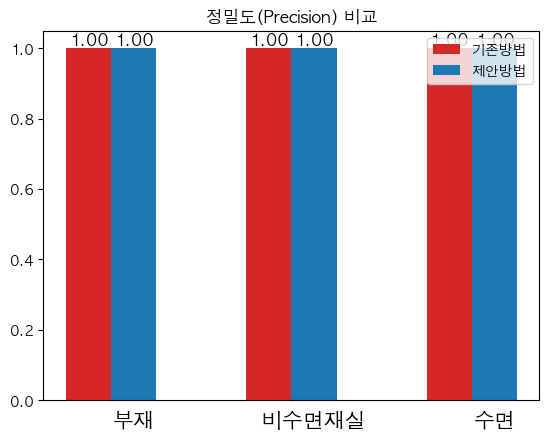

In [673]:
X1=[1,3,5]
data1 = [hatinroo_absence_precision,hatinroo_active_precision,hatinroo_sleep_precision]
bar1 = plt.bar(X1, data1,color='tab:red',width=0.5)

for rect in bar1:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width()/2.0, height, '%.2f' % height, ha='center', va='bottom', size = 12)    

X2=[1+0.5,3+0.5,5+0.5]
data2 = [knu_absence_precision,knu_active_precision,knu_sleep_precision]
bar2 = plt.bar(X2, data2,color='tab:blue',width=0.5)

for rect in bar2:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width()/2.0, height, '%.2f' % height, ha='center', va='bottom', size = 12)    

ticklabel=['부재','비수면재실','수면']
plt.xticks(X2,ticklabel,fontsize=15,rotation=0)

plt.title("정밀도(Precision) 비교")
plt.tick_params(
    axis='x',              
    bottom=False)
plt.legend(['기존방법','제안방법'])
plt.show()

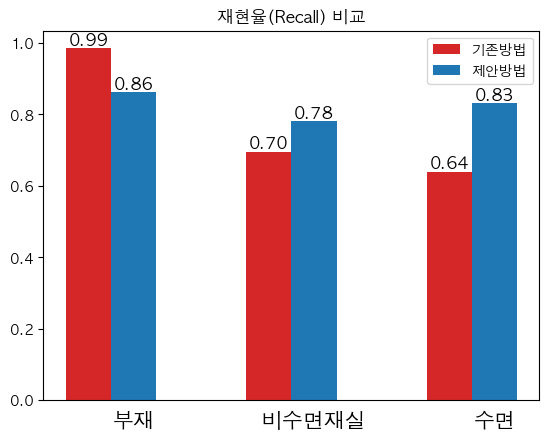

In [674]:
X1=[1,3,5]
data1 = [hatinroo_absence_recall,hatinroo_active_recall,hatinroo_sleep_recall]
bar1 = plt.bar(X1, data1,color='tab:red',width=0.5)

for rect in bar1:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width()/2.0, height, '%.2f' % height, ha='center', va='bottom', size = 12)   

X2=[1+0.5,3+0.5,5+0.5]
data2 = [knu_absence_recall,knu_active_recall,knu_sleep_recall]

bar2 = plt.bar(X2, data2,color='tab:blue',width=0.5)

for rect in bar2:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width()/2.0, height, '%.2f' % height, ha='center', va='bottom', size = 12)   

ticklabel=['부재','비수면재실','수면']
plt.xticks(X2,ticklabel,fontsize=15,rotation=0)

plt.title("재현율(Recall) 비교")
plt.tick_params(
    axis='x',              
    bottom=False)
plt.legend(['기존방법','제안방법'])
plt.show()

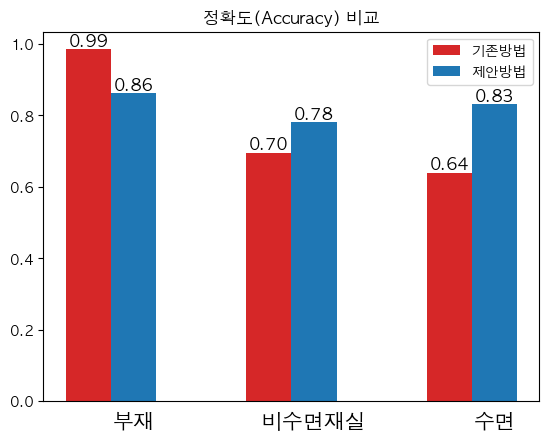

In [675]:
X1=[1,3,5]
data1 = [hatinroo_absence_accuracy,hatinroo_active_accuracy,hatinroo_sleep_accuracy]
bar1 = plt.bar(X1, data1,color='tab:red',width=0.5)

for rect in bar1:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width()/2.0, height, '%.2f' % height, ha='center', va='bottom', size = 12)   

X2=[1+0.5,3+0.5,5+0.5]
data2 = [knu_absence_accuracy,knu_active_accuracy,knu_sleep_accuracy]

bar2 = plt.bar(X2, data2,color='tab:blue',width=0.5)

for rect in bar2:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width()/2.0, height, '%.2f' % height, ha='center', va='bottom', size = 12)   

ticklabel=['부재','비수면재실','수면']
plt.xticks(X2,ticklabel,fontsize=15,rotation=0)

plt.title("정확도(Accuracy) 비교")
plt.tick_params(
    axis='x',              
    bottom=False)
plt.legend(['기존방법','제안방법'])
plt.show()

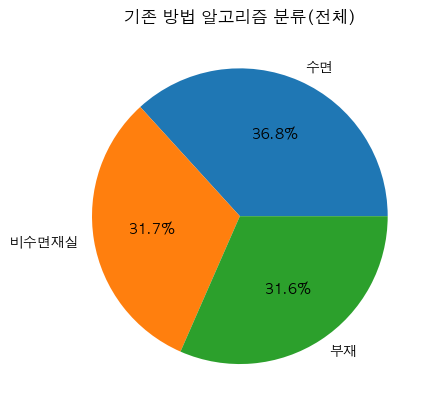

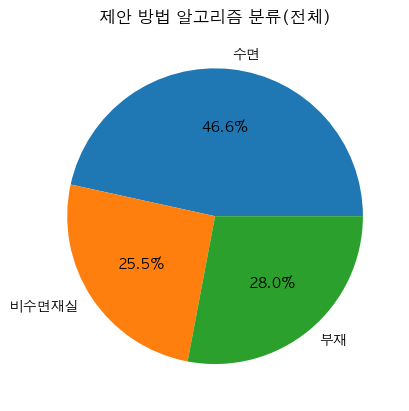

In [676]:
#하틴루 알고리즘, 강남대 알고리즘 전체 비교 시각화

statusSleep = len(resultDf[resultDf['status'] == 4])/len(resultDf)
statusAbsence = len(resultDf[resultDf['status'] == 0])/len(resultDf)
statusActive = len(resultDf[(resultDf['status'] == 2) | (resultDf['status'] == 3)])/len(resultDf)
plt.pie([statusSleep, statusActive, statusAbsence], labels=['수면','비수면재실', '부재'], autopct='%.1f%%',colors=colors)
plt.title('기존 방법 알고리즘 분류(전체)')
# plt.savefig("./figs/absence(하틴루).png", bbox_inches='tight')
plt.show()

labelSleep = len(resultDf[resultDf['label'] == 4])/len(resultDf)
labelAbsence = len(resultDf[resultDf['label'] == 0])/len(resultDf)
labelActive = len(resultDf[resultDf['label'] == 1])/len(resultDf)
plt.pie([labelSleep, labelActive, labelAbsence], labels=['수면', '비수면재실', '부재'], autopct='%.1f%%',colors=colors)
plt.title('제안 방법 알고리즘 분류(전체)')
# plt.savefig("./figs/absence(강남대).png", bbox_inches='tight')
plt.show()

In [659]:
noPersonalizationResultDf = pd.DataFrame()
test = sleep
test['real_label'] = 4
result_df = pd.DataFrame()

for i in range(7):
    test1 = test[test['userId'] == i]
    test1['label'] = 5

    cond_1 = (
        (test1['d2'].isnull())
        & (test1['hr_conv'] == 0)
        & (test1['br_conv'] == 0)
        & ((test1['mot'] == 0 ) | (test1['speed'] == 0))
    )

    cond_1_1 = (
        (~test1['d2'].isnull())
        & (test1['d2'] < test1[test1['d2'] > 0 ]['d2'].min() * 1.4)
    )

    test1.loc[cond_1, 'label'] = 0
    test1.loc[cond_1_1, 'label'] = 0

    cond_2 = (
        (test1['light'].rolling(10).sum() < 10)
        & (test1['label'] != 0)
    )

    test1.loc[cond_2, 'label'] = 4
    test1.loc[test1['label'] == 5, 'label'] = 1

    cond_3 = (
        (test1[test1['userId'] == i]['mot'].rolling(10).mean() <= 0)
        & (test1['label'] == 1)
    )

    test1.loc[cond_3, 'label'] = 4

    result_df = pd.concat([result_df, test1], ignore_index=True)

noPersonalizationResultDf = pd.concat([noPersonalizationResultDf, result_df], ignore_index=True)

/var/folders/3c/mjclf_6d0wlfk3rpvcxcvdz80000gn/T/ipykernel_42898/3241359815.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test1['label'] = 5
/var/folders/3c/mjclf_6d0wlfk3rpvcxcvdz80000gn/T/ipykernel_42898/3241359815.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test1['label'] = 5
/var/folders/3c/mjclf_6d0wlfk3rpvcxcvdz80000gn/T/ipykernel_42898/3241359815.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = va

In [660]:
#하틴루 알고리즘, 강남대 알고리즘 전체 비교 시각화

statusSleep = len(result_df[result_df['status'] == 4])/len(result_df)
statusAbsence = len(result_df[result_df['status'] == 0])/len(result_df)
statusActive = len(result_df[(result_df['status'] == 2) | (result_df['status'] == 3)])/len(result_df)

labelSleep = len(result_df[result_df['label'] == 4])/len(result_df)
labelAbsence = len(result_df[result_df['label'] == 0])/len(result_df)
labelActive = len(result_df[result_df['label'] == 1])/len(result_df)

df = result_df[(result_df['userId']==0)|(result_df['userId']==2)|(result_df['userId']==3)|(result_df['userId']==4)]
d2labelSleep = len(df[df['label'] == 4])/len(df)
d2labelAbsence = len(df[df['label'] == 0])/len(df)
d2labelActive = len(df[df['label'] == 1])/len(df)

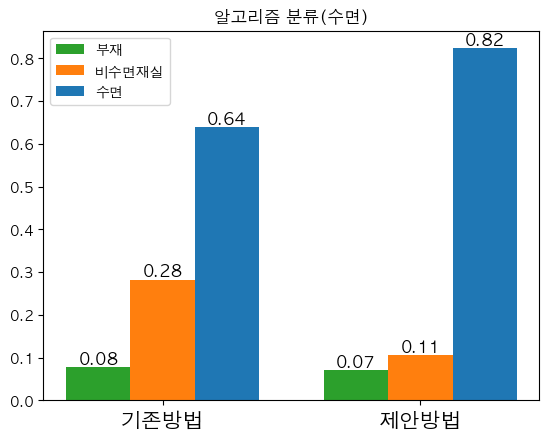

In [661]:
X1=[1,3]
data1 = [statusAbsence,labelAbsence]
bar1 = plt.bar(X1, data1,color='tab:green',width=0.5)

for rect in bar1:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width()/2.0, height, '%.2f' % height, ha='center', va='bottom', size = 12)    

X2=[1+0.5,3+0.5]
data2 = [statusActive,labelActive]
bar2 = plt.bar(X2, data2,color='tab:orange',width=0.5)

for rect in bar2:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width()/2.0, height, '%.2f' % height, ha='center', va='bottom', size = 12)  

X3=[1+1,3+1]
data3 = [statusSleep,labelSleep]
bar3 = plt.bar(X3, data3,color='tab:blue',width=0.5)

for rect in bar3:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width()/2.0, height, '%.2f' % height, ha='center', va='bottom', size = 12)  

ticklabel=['기존방법','제안방법']
plt.title('알고리즘 분류(수면)')
plt.xticks(X2,ticklabel,fontsize=15,rotation=0)
plt.legend(['부재','비수면재실','수면'])


In [662]:
test = active
test['real_label'] = 1
result_df = pd.DataFrame()

for i in range(7):
    test1 = test[test['userId'] == i]
    test1['label'] = 5

    cond_1 = (
        (test1['d2'].isnull())
        & (test1['hr_conv'] == 0)
        & (test1['br_conv'] == 0)
        & ((test1['mot'] == 0 ) | (test1['speed'] == 0))
    )

    cond_1_1 = (
        (~test1['d2'].isnull())
        & (test1['d2'] < test1[test1['d2'] > 0 ]['d2'].min() * 1.4)
    )

    test1.loc[cond_1, 'label'] = 0
    test1.loc[cond_1_1, 'label'] = 0

    cond_2 = (
        (test1['light'].rolling(10).sum() < 10)
        & (test1['label'] != 0)
    )

    test1.loc[cond_2, 'label'] = 4
    test1.loc[test1['label'] == 5, 'label'] = 1

    cond_3 = (
        (test1[test1['userId'] == i]['mot'].rolling(10).mean() <= 0)
        & (test1['label'] == 1)
    )

    test1.loc[cond_3, 'label'] = 4

    result_df = pd.concat([result_df, test1], ignore_index=True)

noPersonalizationResultDf = pd.concat([noPersonalizationResultDf, result_df], ignore_index=True)

/var/folders/3c/mjclf_6d0wlfk3rpvcxcvdz80000gn/T/ipykernel_42898/813484325.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test1['label'] = 5
/var/folders/3c/mjclf_6d0wlfk3rpvcxcvdz80000gn/T/ipykernel_42898/813484325.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test1['label'] = 5
/var/folders/3c/mjclf_6d0wlfk3rpvcxcvdz80000gn/T/ipykernel_42898/813484325.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value

In [663]:
test = absence
test['real_label'] = 0
result_df = pd.DataFrame()

for i in range(7):
    test1 = test[test['userId'] == i]
    test1['label'] = 5

    cond_1 = (
        (test1['d2'].isnull())
        & (test1['hr_conv'] == 0)
        & (test1['br_conv'] == 0)
        & ((test1['mot'] == 0 ) | (test1['speed'] == 0))
    )

    cond_1_1 = (
        (~test1['d2'].isnull())
        & (test1['d2'] < test1[test1['d2'] > 0 ]['d2'].min() * 1.4)
    )

    test1.loc[cond_1, 'label'] = 0
    test1.loc[cond_1_1, 'label'] = 0

    cond_2 = (
        (test1['light'].rolling(10).sum() < 10)
        & (test1['label'] != 0)
    )

    test1.loc[cond_2, 'label'] = 4
    test1.loc[test1['label'] == 5, 'label'] = 1

    cond_3 = (
        (test1[test1['userId'] == i]['mot'].rolling(15).mean() <= motQuntaile50Array[i])
        & (test1['label'] == 1)
    )

    test1.loc[cond_3, 'label'] = 4

    result_df = pd.concat([result_df, test1], ignore_index=True)

noPersonalizationResultDf = pd.concat([noPersonalizationResultDf, result_df], ignore_index=True)

/var/folders/3c/mjclf_6d0wlfk3rpvcxcvdz80000gn/T/ipykernel_42898/3764426548.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test1['label'] = 5
/var/folders/3c/mjclf_6d0wlfk3rpvcxcvdz80000gn/T/ipykernel_42898/3764426548.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test1['label'] = 5
/var/folders/3c/mjclf_6d0wlfk3rpvcxcvdz80000gn/T/ipykernel_42898/3764426548.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = va

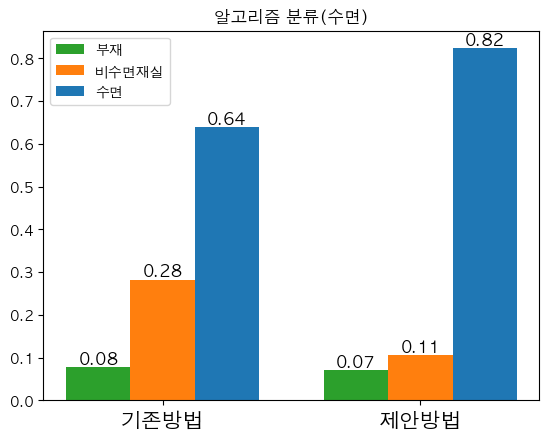

In [664]:
X1=[1,3]
data1 = [statusAbsence,labelAbsence]
bar1 = plt.bar(X1, data1,color='tab:green',width=0.5)

for rect in bar1:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width()/2.0, height, '%.2f' % height, ha='center', va='bottom', size = 12)    

X2=[1+0.5,3+0.5]
data2 = [statusActive,labelActive]
bar2 = plt.bar(X2, data2,color='tab:orange',width=0.5)

for rect in bar2:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width()/2.0, height, '%.2f' % height, ha='center', va='bottom', size = 12)  

X3=[1+1,3+1]
data3 = [statusSleep,labelSleep]
bar3 = plt.bar(X3, data3,color='tab:blue',width=0.5)

for rect in bar3:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width()/2.0, height, '%.2f' % height, ha='center', va='bottom', size = 12)  

ticklabel=['기존방법','제안방법']
plt.title('알고리즘 분류(수면)')
plt.xticks(X2,ticklabel,fontsize=15,rotation=0)
plt.legend(['부재','비수면재실','수면'])


([<matplotlib.axis.XTick at 0x133421ed0>,
 [Text(1, 0, '박하원'),
  Text(2, 0, '하효은'),
  Text(3, 0, '이민우'),
  Text(4, 0, '강명균'),
  Text(5, 0, '유지원'),
  Text(6, 0, '손정민'),
  Text(7, 0, '이채별')])

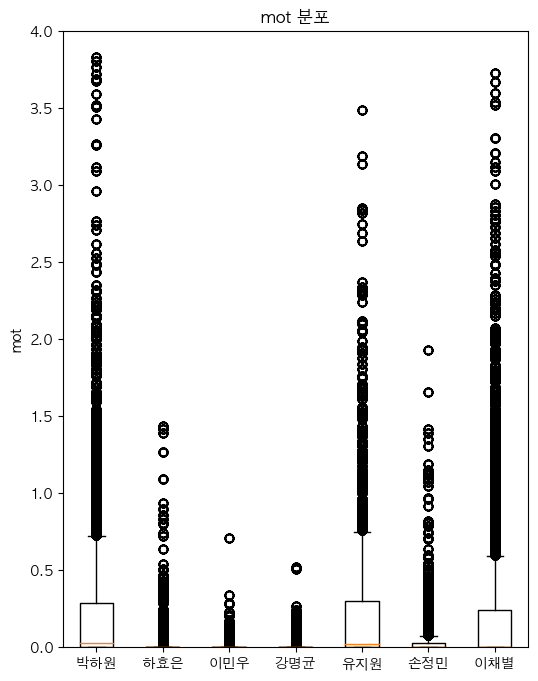

In [665]:
colArray = []

for i in range(0,7):
    Df = resultDf[(resultDf['userId'] == i) & (resultDf['real_label'] == 4)]
    Df.reset_index(drop=True)
    colArray.append(Df['mot'])  
plt.figure(figsize=(6,8))
plt.boxplot(colArray)
plt.ylabel('mot')
plt.title("mot 분포")
plt.ylim([0, 4])
plt.xticks([1,2,3,4,5,6,7],labels=[nameArray[0],nameArray[1],nameArray[2],nameArray[3],nameArray[4],nameArray[5],nameArray[6]])

([<matplotlib.axis.XTick at 0x1331b9750>,
 [Text(1, 0, '박하원'),
  Text(2, 0, '하효은'),
  Text(3, 0, '이민우'),
  Text(4, 0, '강명균'),
  Text(5, 0, '유지원'),
  Text(6, 0, '손정민'),
  Text(7, 0, '이채별')])

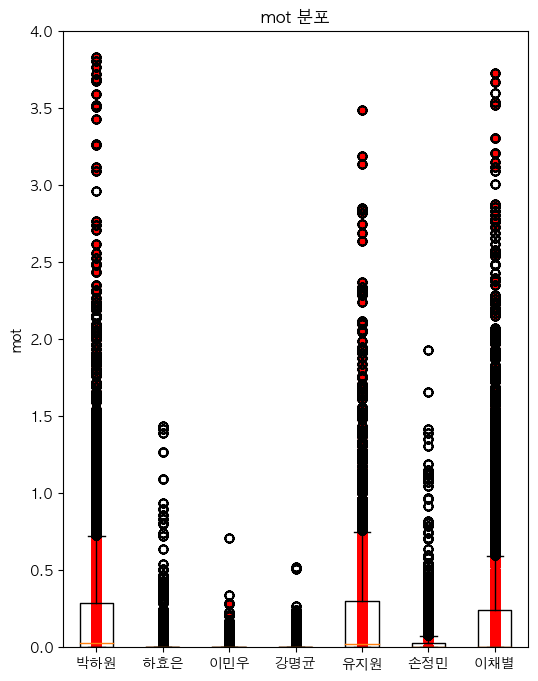

In [666]:
sleepColArray = []
notSleepColArray = []
position = [1,2,3,4,5,6,7]

for i in range(0,7):
    Df = resultDf[(resultDf['userId'] == i) & (resultDf['real_label'] == 4)]
    Df.reset_index(drop=True)
    Df_sleep = Df
    Df_notsleep = Df[Df['status']!=4]
    sleepColArray.append(Df_sleep['mot'])
    notSleepColArray.append(Df_notsleep['mot'])
plt.figure(figsize=(6,8))
plt.boxplot(sleepColArray,positions=position)
for i in range(1,8):
    plt.scatter([i]*len(notSleepColArray[i-1]),notSleepColArray[i-1],color='red',alpha=0.3)
plt.ylim([0, 4])
plt.ylabel('mot')
plt.title("mot 분포")
plt.xticks([1,2,3,4,5,6,7],labels=[nameArray[0],nameArray[1],nameArray[2],nameArray[3],nameArray[4],nameArray[5],nameArray[6]])


In [678]:
pip install scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 27.6 MB/s eta 0:00:0000:010:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.2/37.2 MB 20.1 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.2/302.2 kB 10.4 MB/s eta 0:00:00

[notice] A new release of pip is available: 23.0 -> 23.2.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [706]:
import sklearn
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

allresult = pd.read_csv("/Users/hyennaeon/Desktop/Hatinroo/HatinrooData/allresultData.csv")

In [724]:
df = allresult
df['true'] = 0
df['pred'] = 0
df.loc[df['real_label'] == 4, 'true'] = 1
df.loc[df['label'] == 4, 'pred'] = 1
label_true = df['true']
label_pred = df['pred']

knu_sleep_accuracy = accuracy_score(label_true,label_pred)
knu_sleep_precision = precision_score(label_true,label_pred)
knu_sleep_recall = recall_score(label_true,label_pred)
knu_sleep_f1score = f1_score(label_true, label_pred)

In [725]:
df = allresult
df['true'] = 0
df['pred'] = 0
df.loc[df['real_label'] == 1, 'true'] = 1
df.loc[df['label'] == 1, 'pred'] = 1
label_true = df['true']
label_pred = df['pred']

knu_active_accuracy = accuracy_score(label_true,label_pred)
knu_active_precision = precision_score(label_true,label_pred)
knu_active_recall = recall_score(label_true,label_pred)
knu_active_f1score = f1_score(label_true, label_pred)

In [748]:
df = allresult[(allresult['userId'] == 0)|(allresult['userId'] == 2)|(allresult['userId'] == 3)|(allresult['userId'] == 5)]
df['true'] = 0
df['pred'] = 0
df.loc[df['real_label'] == 0, 'true'] = 1
df.loc[df['label'] == 0, 'pred'] = 1
label_true = df['true']
label_pred = df['pred']

knu_absence_accuracy = accuracy_score(label_true,label_pred)
knu_absence_precision = precision_score(label_true,label_pred)
knu_absence_recall = recall_score(label_true,label_pred)
knu_absence_f1score = f1_score(label_true, label_pred)

/var/folders/3c/mjclf_6d0wlfk3rpvcxcvdz80000gn/T/ipykernel_42898/4210934319.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['true'] = 0
/var/folders/3c/mjclf_6d0wlfk3rpvcxcvdz80000gn/T/ipykernel_42898/4210934319.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pred'] = 0


In [727]:
df = allresult
df['true'] = 0
df['pred'] = 0
df.loc[df['real_label'] == 4, 'true'] = 1
df.loc[df['status'] == 4, 'pred'] = 1
label_true = df['true']
label_pred = df['pred']

hatinroo_sleep_accuracy = accuracy_score(label_true,label_pred)
hatinroo_sleep_precision = precision_score(label_true,label_pred)
hatinroo_sleep_recall = recall_score(label_true,label_pred)
hatinroo_sleep_f1score = f1_score(label_true, label_pred)


In [728]:
df = allresult
df['true'] = 0
df['pred'] = 0
df.loc[df['real_label'] == 1, 'true'] = 1
df.loc[(df['status'] == 2)|(df['status'] == 3), 'pred'] = 1
label_true = df['true']
label_pred = df['pred']

hatinroo_active_accuracy = accuracy_score(label_true,label_pred)
hatinroo_active_precision = precision_score(label_true,label_pred)
hatinroo_active_recall = recall_score(label_true,label_pred)
hatinroo_active_f1score = f1_score(label_true, label_pred)

In [729]:
df = allresult
df['true'] = 0
df['pred'] = 0
df.loc[df['real_label'] == 0, 'true'] = 1
df.loc[df['status'] == 0, 'pred'] = 1
label_true = df['true']
label_pred = df['pred']

hatinroo_absence_accuracy = accuracy_score(label_true,label_pred)
hatinroo_absence_precision = precision_score(label_true,label_pred)
hatinroo_absence_recall = recall_score(label_true,label_pred)
hatinroo_absence_f1score = f1_score(label_true, label_pred)

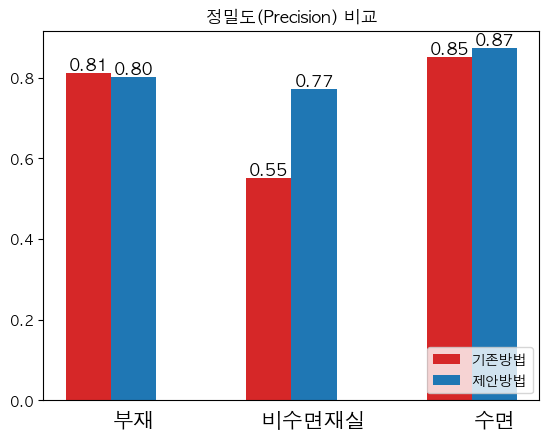

In [741]:
X1=[1,3,5]
data1 = [hatinroo_absence_precision,hatinroo_active_precision,hatinroo_sleep_precision]
bar1 = plt.bar(X1, data1,color='tab:red',width=0.5)

for rect in bar1:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width()/2.0, height, '%.2f' % height, ha='center', va='bottom', size = 12)    

X2=[1+0.5,3+0.5,5+0.5]
data2 = [knu_absence_precision,knu_active_precision,knu_sleep_precision]
bar2 = plt.bar(X2, data2,color='tab:blue',width=0.5)

for rect in bar2:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width()/2.0, height, '%.2f' % height, ha='center', va='bottom', size = 12)    

ticklabel=['부재','비수면재실','수면']
plt.xticks(X2,ticklabel,fontsize=15,rotation=0)

plt.title("정밀도(Precision) 비교")
plt.tick_params(
    axis='x',              
    bottom=False)
plt.legend(['기존방법','제안방법'], loc='lower right')
plt.show()

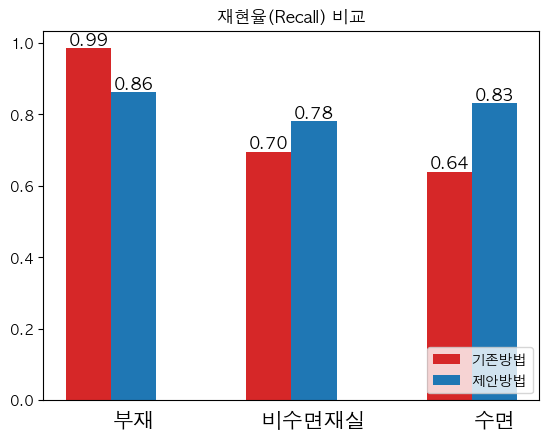

In [742]:
X1=[1,3,5]
data1 = [hatinroo_absence_recall,hatinroo_active_recall,hatinroo_sleep_recall]
bar1 = plt.bar(X1, data1,color='tab:red',width=0.5)

for rect in bar1:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width()/2.0, height, '%.2f' % height, ha='center', va='bottom', size = 12)   

X2=[1+0.5,3+0.5,5+0.5]
data2 = [knu_absence_recall,knu_active_recall,knu_sleep_recall]

bar2 = plt.bar(X2, data2,color='tab:blue',width=0.5)

for rect in bar2:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width()/2.0, height, '%.2f' % height, ha='center', va='bottom', size = 12)   

ticklabel=['부재','비수면재실','수면']
plt.xticks(X2,ticklabel,fontsize=15,rotation=0)

plt.title("재현율(Recall) 비교")
plt.tick_params(
    axis='x',              
    bottom=False)
plt.legend(['기존방법','제안방법'], loc='lower right')
plt.show()

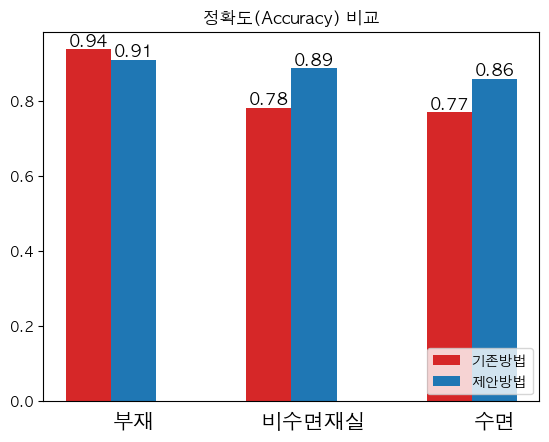

In [743]:
X1=[1,3,5]
data1 = [hatinroo_absence_accuracy,hatinroo_active_accuracy,hatinroo_sleep_accuracy]
bar1 = plt.bar(X1, data1,color='tab:red',width=0.5)

for rect in bar1:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width()/2.0, height, '%.2f' % height, ha='center', va='bottom', size = 12)   

X2=[1+0.5,3+0.5,5+0.5]
data2 = [knu_absence_accuracy,knu_active_accuracy,knu_sleep_accuracy]

bar2 = plt.bar(X2, data2,color='tab:blue',width=0.5)

for rect in bar2:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width()/2.0, height, '%.2f' % height, ha='center', va='bottom', size = 12)   

ticklabel=['부재','비수면재실','수면']
plt.xticks(X2,ticklabel,fontsize=15,rotation=0)

plt.title("정확도(Accuracy) 비교")
plt.tick_params(
    axis='x',              
    bottom=False)

plt.legend(['기존방법','제안방법'], loc='lower right')
# plt.legend(loc='lower right')
plt.show()

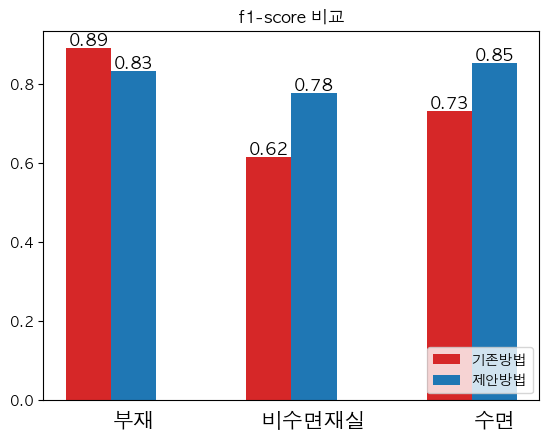

In [744]:
X1=[1,3,5]
data1 = [hatinroo_absence_f1score,hatinroo_active_f1score,hatinroo_sleep_f1score]
bar1 = plt.bar(X1, data1,color='tab:red',width=0.5)

for rect in bar1:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width()/2.0, height, '%.2f' % height, ha='center', va='bottom', size = 12)   

X2=[1+0.5,3+0.5,5+0.5]
data2 = [knu_absence_f1score,knu_active_f1score,knu_sleep_f1score]

bar2 = plt.bar(X2, data2,color='tab:blue',width=0.5)

for rect in bar2:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width()/2.0, height, '%.2f' % height, ha='center', va='bottom', size = 12)   

ticklabel=['부재','비수면재실','수면']
plt.xticks(X2,ticklabel,fontsize=15,rotation=0)

plt.title("f1-score 비교")
plt.tick_params(
    axis='x',              
    bottom=False)
plt.legend(['기존방법','제안방법'], loc='lower right')
plt.show()

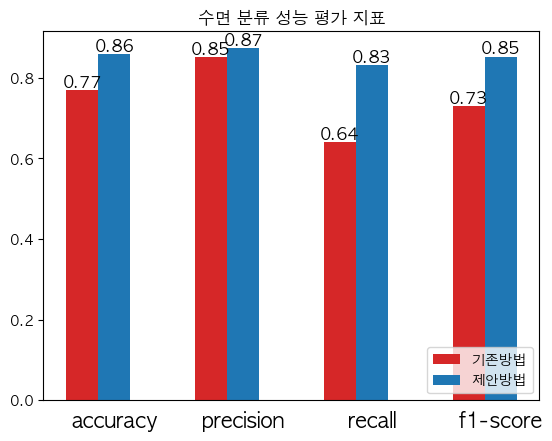

In [745]:
X1=[1,3,5,7]
data1 = [hatinroo_sleep_accuracy,hatinroo_sleep_precision,hatinroo_sleep_recall, hatinroo_sleep_f1score]
bar1 = plt.bar(X1, data1,color='tab:red',width=0.5)

for rect in bar1:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width()/2.0, height, '%.2f' % height, ha='center', va='bottom', size = 12)   

X2=[1+0.5,3+0.5,5+0.5,7+0.5]
data2 = [knu_sleep_accuracy,knu_sleep_precision,knu_sleep_recall, knu_sleep_f1score]

bar2 = plt.bar(X2, data2,color='tab:blue',width=0.5)

for rect in bar2:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width()/2.0, height, '%.2f' % height, ha='center', va='bottom', size = 12)   

ticklabel=['accuracy','precision','recall','f1-score']
plt.xticks(X2,ticklabel,fontsize=15,rotation=0)

plt.title("수면 분류 성능 평가 지표")
plt.tick_params(
    axis='x',              
    bottom=False)
plt.legend(['기존방법','제안방법'], loc='lower right')
plt.show()

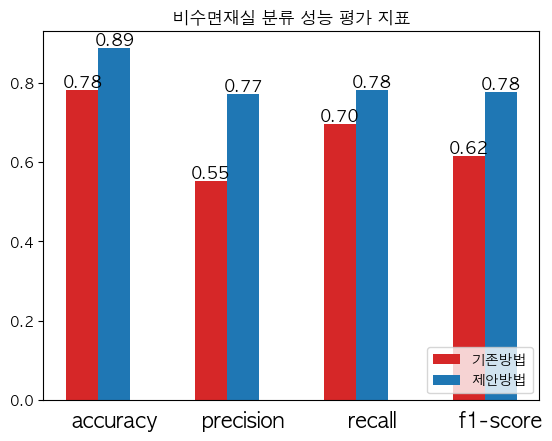

In [746]:
X1=[1,3,5,7]
data1 = [hatinroo_active_accuracy,hatinroo_active_precision,hatinroo_active_recall, hatinroo_active_f1score]
bar1 = plt.bar(X1, data1,color='tab:red',width=0.5)

for rect in bar1:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width()/2.0, height, '%.2f' % height, ha='center', va='bottom', size = 12)   

X2=[1+0.5,3+0.5,5+0.5,7+0.5]
data2 = [knu_active_accuracy,knu_active_precision,knu_active_recall, knu_active_f1score]

bar2 = plt.bar(X2, data2,color='tab:blue',width=0.5)

for rect in bar2:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width()/2.0, height, '%.2f' % height, ha='center', va='bottom', size = 12)   

ticklabel=['accuracy','precision','recall','f1-score']
plt.xticks(X2,ticklabel,fontsize=15,rotation=0)

plt.title("비수면재실 분류 성능 평가 지표")
plt.tick_params(
    axis='x',              
    bottom=False)
plt.legend(['기존방법','제안방법'], loc='lower right')
plt.show()

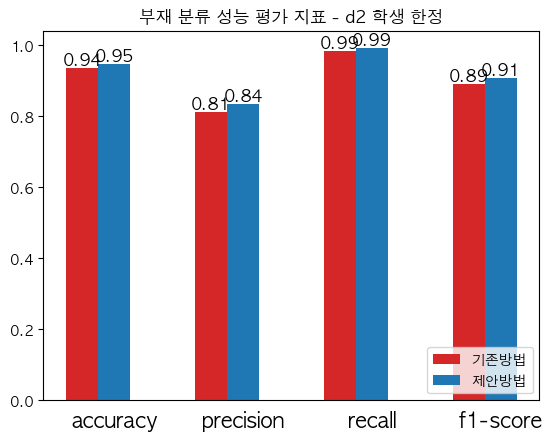

In [750]:
X1=[1,3,5,7]
data1 = [hatinroo_absence_accuracy,hatinroo_absence_precision,hatinroo_absence_recall, hatinroo_absence_f1score]
bar1 = plt.bar(X1, data1,color='tab:red',width=0.5)

for rect in bar1:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width()/2.0, height, '%.2f' % height, ha='center', va='bottom', size = 12)   

X2=[1+0.5,3+0.5,5+0.5,7+0.5]
data2 = [knu_absence_accuracy,knu_absence_precision,knu_absence_recall, knu_absence_f1score]

bar2 = plt.bar(X2, data2,color='tab:blue',width=0.5)

for rect in bar2:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width()/2.0, height, '%.2f' % height, ha='center', va='bottom', size = 12)   

ticklabel=['accuracy','precision','recall','f1-score']
plt.xticks(X2,ticklabel,fontsize=15,rotation=0)

plt.title("부재 분류 성능 평가 지표 - d2 학생 한정")
plt.tick_params(
    axis='x',              
    bottom=False)
plt.legend(['기존방법','제안방법'], loc='lower right')
plt.show()